In [1]:
!pip install scikit-image pillow
!pip install torch torchvision
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import functional as TF
import torch.nn as nn
from torchvision import models, transforms
import pandas as pd
import lpips
import os
from PIL import Image

In [3]:
# Cargar el modelo VGG16 preentrenado
def cargar_vgg_model():
    vgg = models.vgg16(pretrained=True).features
    vgg.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vgg = vgg.to(device)
    return vgg, device

In [4]:
#Preprocesar las imágenes
# Transformaciones necesarias para PyTorch
transform = transforms.Compose([
    transforms.Resize((224, 224)), #(224x224, normalización)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Extraer características hasta una capa específica
def extraer_caracteristicas(img, vgg, device, layer_idx):
    x = img.to(device)
    for i, layer in enumerate(vgg):
        x = layer(x)
        if i == layer_idx:
            break
    return x

In [5]:
# Función para calcular matriz gram
def calcular_gram_matrix(features):
    # Tamaño de tensor de acarcteríticas ej: (1×256×28×28)
    n, c, h, w = features.size()
    # Forma util para calcular correlaciones
    features = features.view(c, h * w)
    # Matriz gram de tamaño C×C (ej 256×256).
    gram = torch.mm(features, features.t())
    return gram

def metrica_gram_matrix_similarity(style_img, wct_img, vgg, device, layer_idx):
    # Extraer características de imagen de estilo y de WCT para una capa específica
    features_style = extraer_caracteristicas(style_img, vgg, device, layer_idx=layer_idx)
    features_wct = extraer_caracteristicas(wct_img, vgg, device, layer_idx=layer_idx)

    # Calcular matriz gram de cada imagen
    gram_style = calcular_gram_matrix(features_style)
    gram_wct = calcular_gram_matrix(features_wct)

    # Calcular similitud de coseno de ambas matrices
    similarity = torch.cosine_similarity(gram_style.flatten(), gram_wct.flatten(), dim=0)
    return similarity.item()

In [6]:
# Métrica de Perceptual Loss
def metrica_perceptual_loss(content_img, wct_img, vgg, device, layer_idx):
    # Extraer características de imagen de contenido y de WCT para una capa específica
    features_content = extraer_caracteristicas(content_img, vgg, device, layer_idx=layer_idx)
    features_wct = extraer_caracteristicas(wct_img, vgg, device, layer_idx=layer_idx)

    # Calcula la pérdida del error cuadrático medio (norma L2) entre los espacios de características extraídos
    perceptual_loss = nn.functional.mse_loss(features_content, features_wct)
    return perceptual_loss.item()

In [7]:
# Métrica de SSIM
#Compara bordes, textuturas, contrastes y luminosidad entre la imagen de contenido y la imagen generada wtc

def metrica_ssim(content_img, wct_img): #de 0 a 1
    # Asegurarse de que ambas imágenes están en escala de grises para SSIM
    content_gray = cv2.cvtColor(content_img, cv2.COLOR_RGB2GRAY)
    wct_gray = cv2.cvtColor(wct_img, cv2.COLOR_RGB2GRAY)

    # Calcular SSIM entre la imagen de contenido y la generada
    ssim_value, _ = ssim(content_gray, wct_gray, full=True)
    return ssim_value

In [8]:
# Crear el modelo LPIPS y moverlo al dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lpips_model = lpips.LPIPS(net='vgg').to(device)

def metrica_lpips(style_img, wct_img, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Calcula la métrica LPIPS entre la imagen de estilo y la generada.
    """
    # Convertir imágenes a tensores y moverlos al dispositivo
    if not isinstance(style_img, torch.Tensor):
        style_img = TF.to_tensor(style_img).unsqueeze(0).to(device)
    if not isinstance(wct_img, torch.Tensor):
        wct_img = TF.to_tensor(wct_img).unsqueeze(0).to(device)

    # Calcular LPIPS
    lpips_value = lpips_model(style_img, wct_img)
    return lpips_value.item()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 55.7MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [9]:
# Función para calcular el tradeoff entre contenido y estilo
def tradeoff_content_style(content_loss, style_similarity, alpha=0.5):
    return alpha * style_similarity - (1 - alpha) * content_loss

In [10]:
# Evaluación completa para múltiples bloques
def evaluacion(content_img_path, style_img_path, wct_img_path, alpha=0.5):
    # Cargar imágenes
    content_img = Image.open(content_img_path).convert("RGB")
    style_img = Image.open(style_img_path).convert("RGB")
    wct_img = Image.open(wct_img_path).convert("RGB")

    # Transformar imágenes
    content_tensor = transform(content_img).unsqueeze(0).to(device)
    style_tensor = transform(style_img).unsqueeze(0).to(device)
    wct_tensor = transform(wct_img).unsqueeze(0).to(device)

    # Asegurarse de que las imágenes tengan el mismo tamaño para métricas
    content_img = np.array(content_img.resize((224, 224)))
    style_img = np.array(style_img.resize((224, 224)))
    wct_img = np.array(wct_img.resize((224, 224)))

    # Mostrar imágenes
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(content_img)
    plt.title("Content Image")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(style_img)
    plt.title("Style Image")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(wct_img)
    plt.title("WCT Image")
    plt.axis("off")
    plt.show()

    # Cargar modelo VGG16
    vgg, _ = cargar_vgg_model()

    # Índices de bloques para evaluar
    bloques_indices = [4, 9, 16, 23, 30]
    resultados_por_bloque = []

    for idx in bloques_indices:
        # Calcular métricas para el bloque actual
        gram_similarity = metrica_gram_matrix_similarity(style_tensor, wct_tensor, vgg, device, layer_idx=idx)
        perceptual_loss = metrica_perceptual_loss(content_tensor, wct_tensor, vgg, device, layer_idx=idx)

        # Calcular el tradeoff entre contenido y estilo
        tradeoff_value = tradeoff_content_style(perceptual_loss, gram_similarity, alpha=alpha)

        # Guardar resultados
        resultados_por_bloque.append({
            "Bloque": f"Bloque {bloques_indices.index(idx) + 1}",
            "Gram Similarity": gram_similarity,
            "Perceptual Loss": perceptual_loss,
            "Content-Style Tradeoff": tradeoff_value
        })

    # Calcular SSIM
    ssim_value = metrica_ssim(content_img, wct_img)

    # Calcular LPIPS
    lpips_value = metrica_lpips(Image.fromarray(style_img), Image.fromarray(wct_img), device)

    # Mostrar resultados
    print("\nDesglose de Resultados por Bloque:")
    for resultado in resultados_por_bloque:
        print(
            f"{resultado['Bloque']}: Gram Similarity: {resultado['Gram Similarity']:.4f}, "
            f"Perceptual Loss: {resultado['Perceptual Loss']:.4f}, "
            f"Content-Style Tradeoff: {resultado['Content-Style Tradeoff']:.4f}"
        )

    # Resultados generales
    resultados_generales = {
        "SSIM (Content vs Generated)": ssim_value,
        "LPIPS (Style vs Generated)": lpips_value
    }

    # Crear DataFrame para gráficos
    df_resultados = pd.DataFrame(resultados_por_bloque)

    # Gráfica 1: Gram Similarity por bloque
    plt.figure(figsize=(8, 5))
    plt.plot(df_resultados["Bloque"], df_resultados["Gram Similarity"], marker='o', label='Gram Similarity')
    plt.title("Similitud de Matriz Gram por Bloque")
    plt.ylabel("Gram Similarity")
    plt.xlabel("Bloque de la Red VGG16")
    plt.legend()
    plt.grid()
    plt.show()

    # Gráfica 2: Perceptual Loss por bloque
    plt.figure(figsize=(8, 5))
    plt.plot(df_resultados["Bloque"], df_resultados["Perceptual Loss"], marker='o', label='Perceptual Loss')
    plt.title("Pérdida Perceptual por Bloque")
    plt.ylabel("Perceptual Loss")
    plt.xlabel("Bloque de la Red VGG16")
    plt.legend()
    plt.grid()
    plt.show()

    # Gráfica 3: Tradeoff entre contenido y estilo por bloque
    plt.figure(figsize=(8, 5))
    plt.plot(df_resultados["Bloque"], df_resultados["Content-Style Tradeoff"], marker='o', label='Content-Style Tradeoff')
    plt.title("Compensación entre Contenido y Estilo por Bloque")
    plt.ylabel("Content-Style Tradeoff")
    plt.xlabel("Bloque de la Red VGG16")
    plt.legend()
    plt.grid()
    plt.show()

    return resultados_generales, resultados_por_bloque


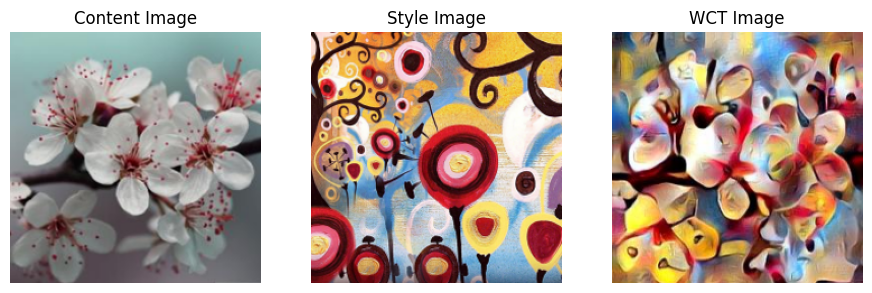


Desglose de Resultados por Bloque:
Bloque 1: Gram Similarity: 0.9890, Perceptual Loss: 3.7822, Content-Style Tradeoff: -1.3966
Bloque 2: Gram Similarity: 0.9651, Perceptual Loss: 22.7987, Content-Style Tradeoff: -10.9168
Bloque 3: Gram Similarity: 0.8852, Perceptual Loss: 68.9987, Content-Style Tradeoff: -34.0567
Bloque 4: Gram Similarity: 0.6668, Perceptual Loss: 13.9225, Content-Style Tradeoff: -6.6278
Bloque 5: Gram Similarity: 0.3497, Perceptual Loss: 1.4886, Content-Style Tradeoff: -0.5694


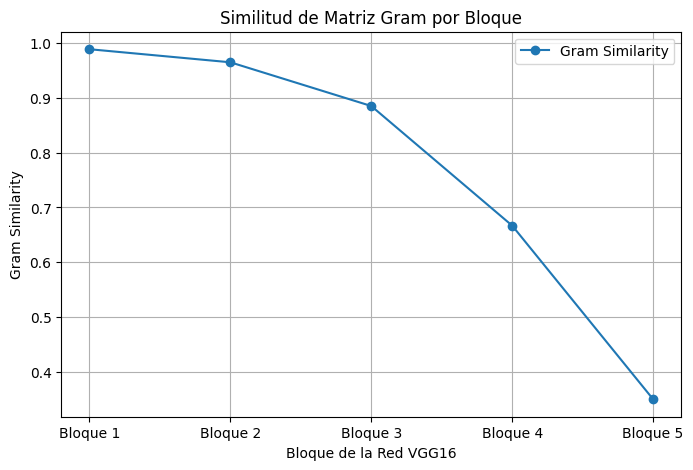

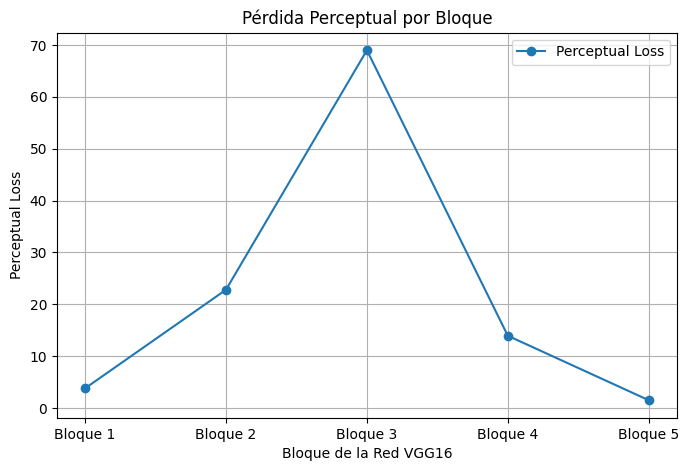

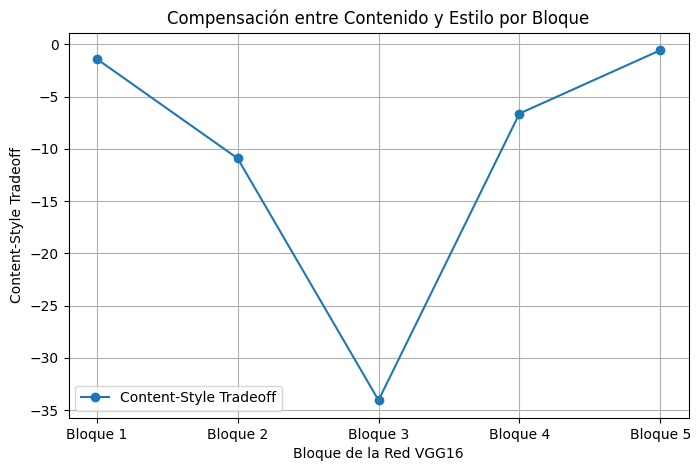


Resultados Generales:
SSIM (Content vs Generated): 0.2191
LPIPS (Style vs Generated): 0.7354


In [11]:
# Rutas de las imágenes de contenido, estilo y generada
content_img_path = '/content/content.png'
style_img_path = '/content/style.png'
wct_img_path = '/content/wct.png'

# Ejecutar evaluación
resultados_generales, resultados_por_bloque = evaluacion(content_img_path, style_img_path, wct_img_path, alpha=0.5)

print("\nResultados Generales:")
for key, value in resultados_generales.items():
    print(f"{key}: {value:.4f}")

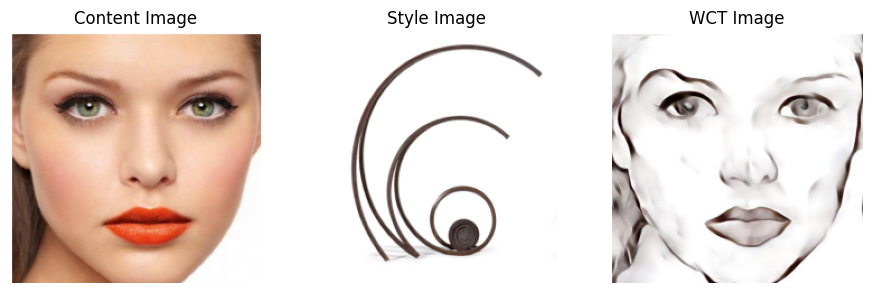


Desglose de Resultados por Bloque:
Bloque 1: Gram Similarity: 0.9808, Perceptual Loss: 2.3849, Content-Style Tradeoff: -0.7020
Bloque 2: Gram Similarity: 0.9293, Perceptual Loss: 9.2606, Content-Style Tradeoff: -4.1656
Bloque 3: Gram Similarity: 0.6981, Perceptual Loss: 26.1189, Content-Style Tradeoff: -12.7104
Bloque 4: Gram Similarity: 0.3541, Perceptual Loss: 8.2661, Content-Style Tradeoff: -3.9560
Bloque 5: Gram Similarity: 0.0755, Perceptual Loss: 1.3451, Content-Style Tradeoff: -0.6348


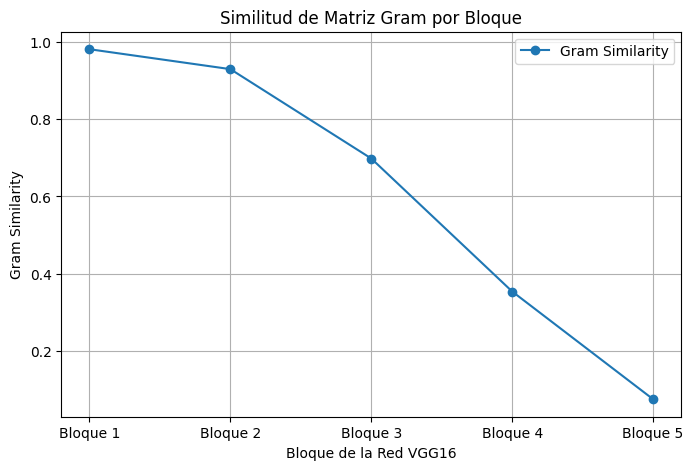

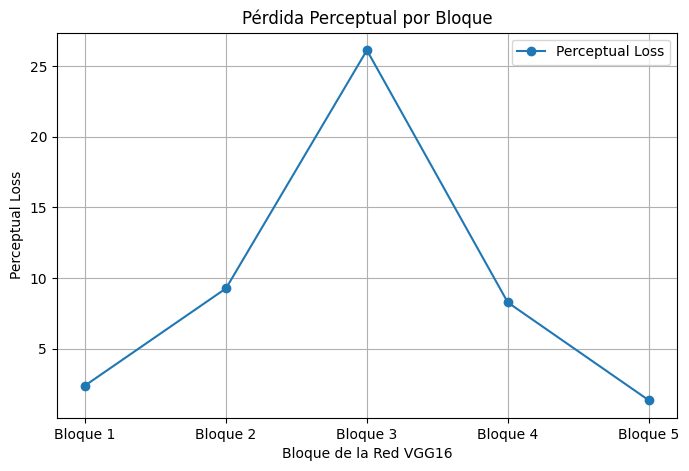

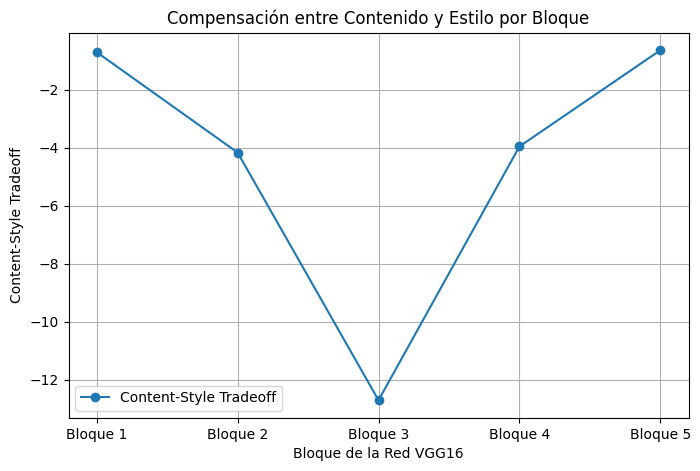


Resultados Generales:
SSIM (Content vs Generated): 0.5941
LPIPS (Style vs Generated): 0.4782


In [12]:
# Rutas de las imágenes de contenido, estilo y generada
content_img_path = '/content/content1.png'
style_img_path = '/content/style1.png'
wct_img_path = '/content/wct1.png'

# Ejecutar evaluación
resultados_generales, resultados_por_bloque = evaluacion(content_img_path, style_img_path, wct_img_path, alpha=0.5)

print("\nResultados Generales:")
for key, value in resultados_generales.items():
    print(f"{key}: {value:.4f}")

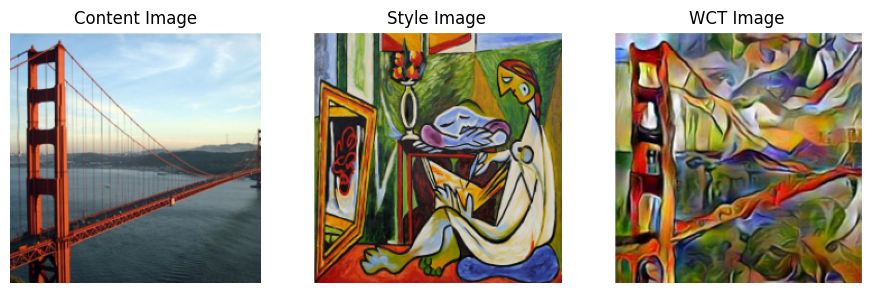


Desglose de Resultados por Bloque:
Bloque 1: Gram Similarity: 0.9830, Perceptual Loss: 4.2180, Content-Style Tradeoff: -1.6175
Bloque 2: Gram Similarity: 0.9593, Perceptual Loss: 23.7769, Content-Style Tradeoff: -11.4088
Bloque 3: Gram Similarity: 0.9191, Perceptual Loss: 67.4941, Content-Style Tradeoff: -33.2875
Bloque 4: Gram Similarity: 0.7303, Perceptual Loss: 12.7225, Content-Style Tradeoff: -5.9961
Bloque 5: Gram Similarity: 0.5335, Perceptual Loss: 2.1596, Content-Style Tradeoff: -0.8131


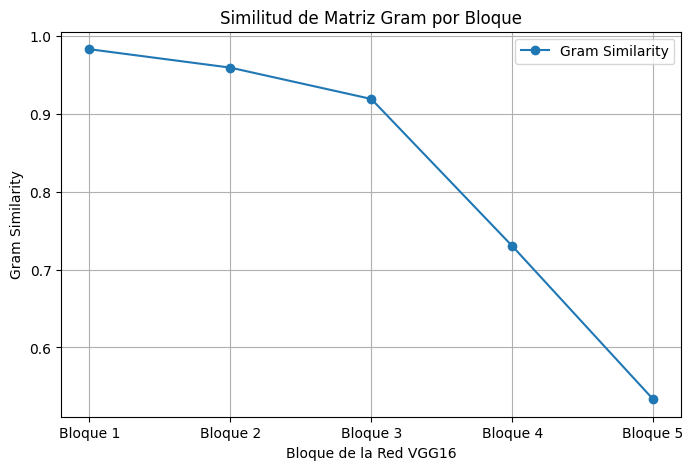

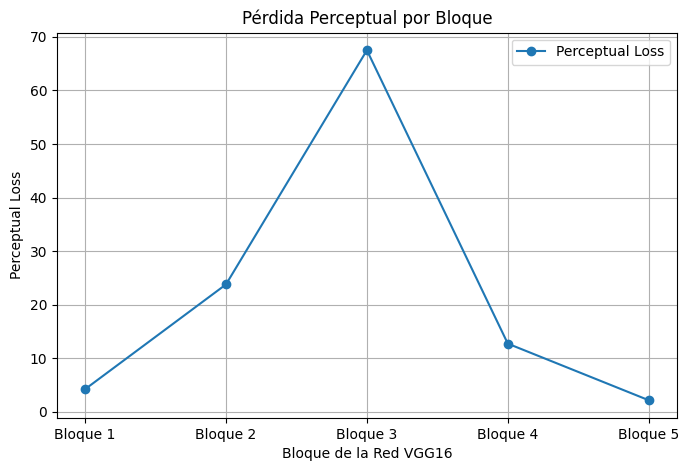

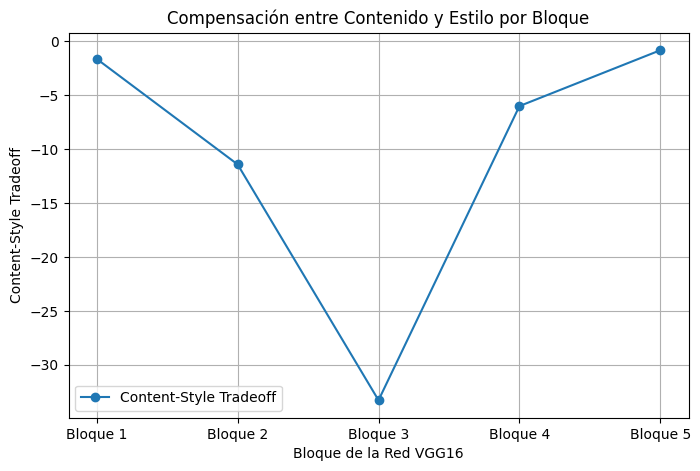


Resultados Generales:
SSIM (Content vs Generated): 0.1673
LPIPS (Style vs Generated): 0.6908


In [13]:
# Rutas de las imágenes de contenido, estilo y generada
content_img_path = '/content/content2.png'
style_img_path = '/content/style2.png'
wct_img_path = '/content/wct2.png'

# Ejecutar evaluación
resultados_generales, resultados_por_bloque = evaluacion(content_img_path, style_img_path, wct_img_path, alpha=0.5)

print("\nResultados Generales:")
for key, value in resultados_generales.items():
    print(f"{key}: {value:.4f}")

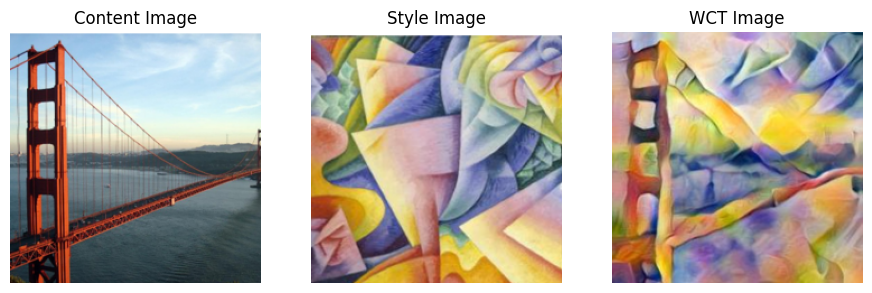


Desglose de Resultados por Bloque:
Bloque 1: Gram Similarity: 0.9845, Perceptual Loss: 2.4539, Content-Style Tradeoff: -0.7347
Bloque 2: Gram Similarity: 0.9850, Perceptual Loss: 14.7250, Content-Style Tradeoff: -6.8700
Bloque 3: Gram Similarity: 0.9318, Perceptual Loss: 41.1104, Content-Style Tradeoff: -20.0893
Bloque 4: Gram Similarity: 0.7794, Perceptual Loss: 10.5821, Content-Style Tradeoff: -4.9013
Bloque 5: Gram Similarity: 0.4344, Perceptual Loss: 2.2739, Content-Style Tradeoff: -0.9198


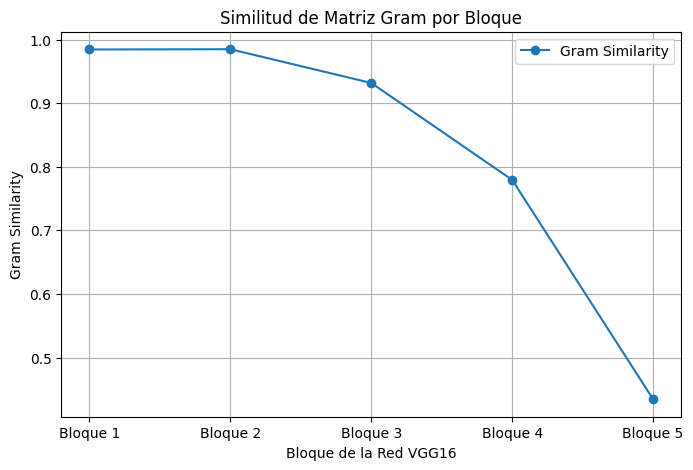

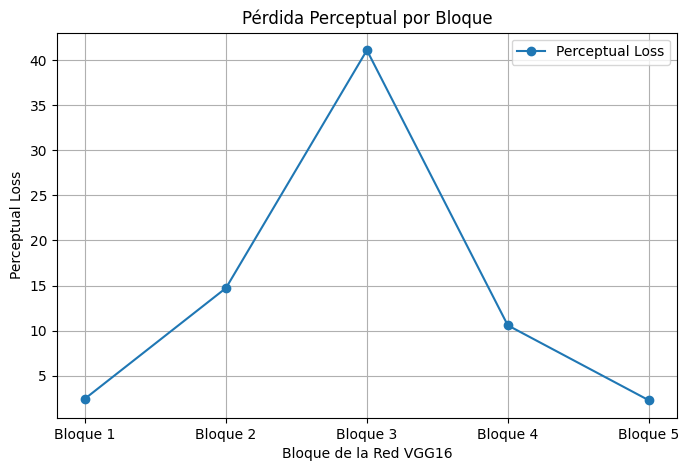

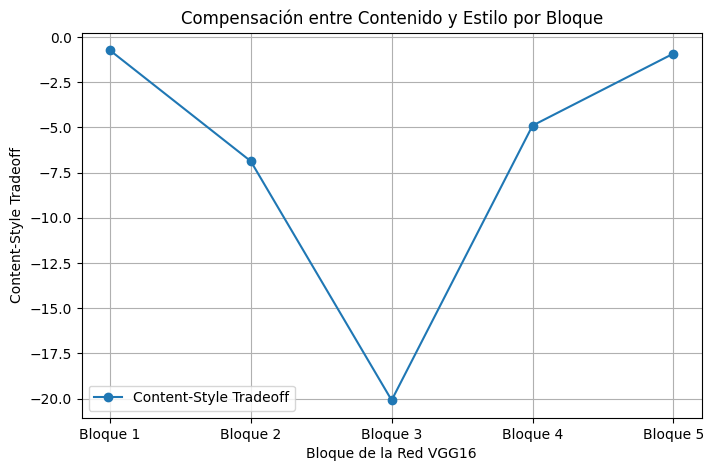


Resultados Generales:
SSIM (Content vs Generated): 0.3110
LPIPS (Style vs Generated): 0.7292


In [14]:
# Rutas de las imágenes de contenido, estilo y generada
content_img_path = '/content/content2.png'
style_img_path = '/content/style3.png'
wct_img_path = '/content/wct3.png'

# Ejecutar evaluación
resultados_generales, resultados_por_bloque = evaluacion(content_img_path, style_img_path, wct_img_path, alpha=0.5)

print("\nResultados Generales:")
for key, value in resultados_generales.items():
    print(f"{key}: {value:.4f}")

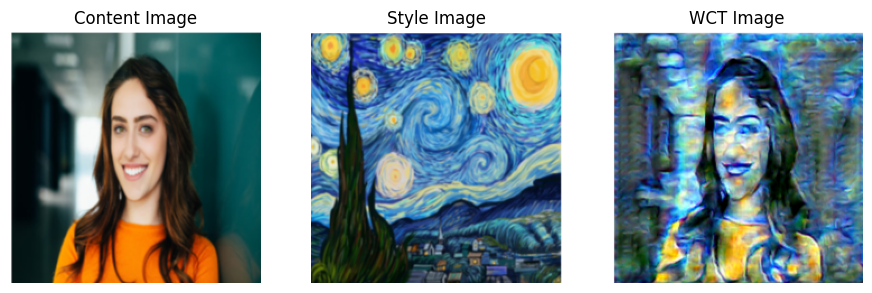


Desglose de Resultados por Bloque:
Bloque 1: Gram Similarity: 0.9773, Perceptual Loss: 2.7682, Content-Style Tradeoff: -0.8954
Bloque 2: Gram Similarity: 0.9608, Perceptual Loss: 18.3512, Content-Style Tradeoff: -8.6952
Bloque 3: Gram Similarity: 0.8648, Perceptual Loss: 37.5476, Content-Style Tradeoff: -18.3414
Bloque 4: Gram Similarity: 0.5369, Perceptual Loss: 8.4971, Content-Style Tradeoff: -3.9801
Bloque 5: Gram Similarity: 0.3463, Perceptual Loss: 0.7624, Content-Style Tradeoff: -0.2081


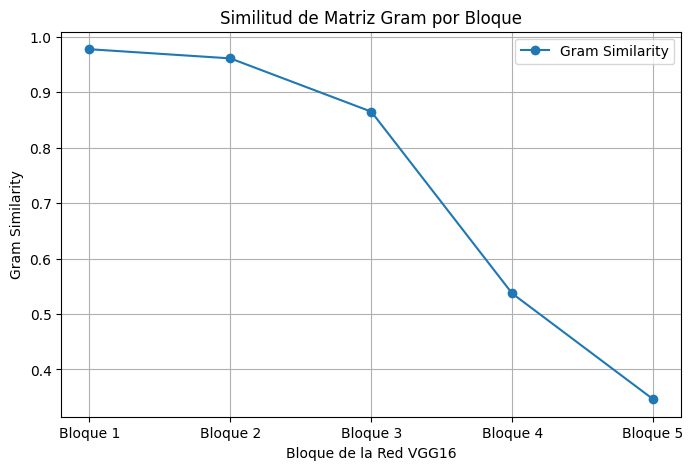

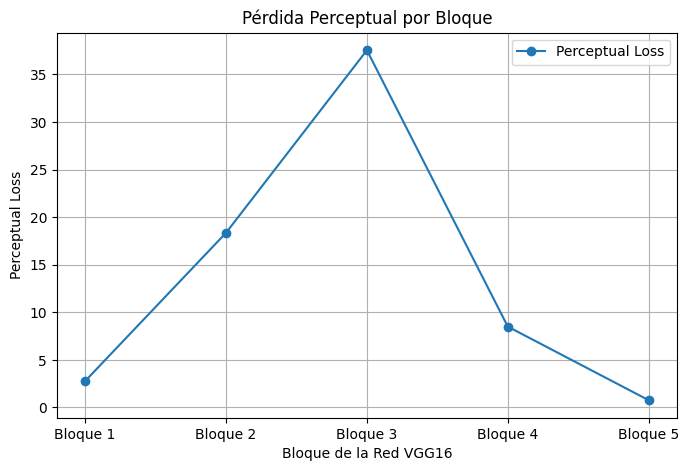

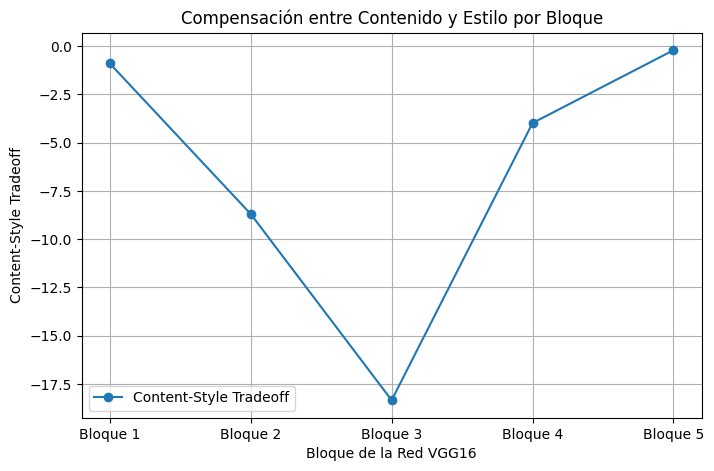


Resultados Generales:
SSIM (Content vs Generated): 0.3711
LPIPS (Style vs Generated): 0.6532


In [16]:
# Rutas de las imágenes de contenido, estilo y generada
content_img_path = '/content/c1.png'
style_img_path = '/content/c2.png'
wct_img_path = '/content/c3.png'

# Ejecutar evaluación
resultados_generales, resultados_por_bloque = evaluacion(content_img_path, style_img_path, wct_img_path, alpha=0.5)

print("\nResultados Generales:")
for key, value in resultados_generales.items():
    print(f"{key}: {value:.4f}")

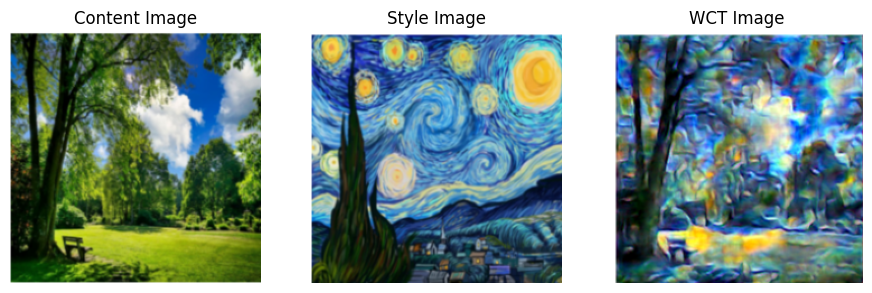


Desglose de Resultados por Bloque:
Bloque 1: Gram Similarity: 0.9773, Perceptual Loss: 3.3022, Content-Style Tradeoff: 0.1214
Bloque 2: Gram Similarity: 0.9553, Perceptual Loss: 18.3858, Content-Style Tradeoff: -2.9129
Bloque 3: Gram Similarity: 0.8720, Perceptual Loss: 30.9801, Content-Style Tradeoff: -5.4984
Bloque 4: Gram Similarity: 0.5367, Perceptual Loss: 4.7747, Content-Style Tradeoff: -0.5256
Bloque 5: Gram Similarity: 0.3532, Perceptual Loss: 0.3919, Content-Style Tradeoff: 0.2042


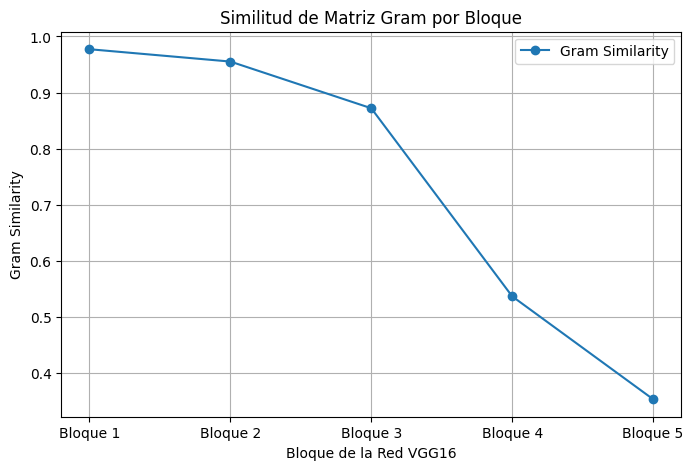

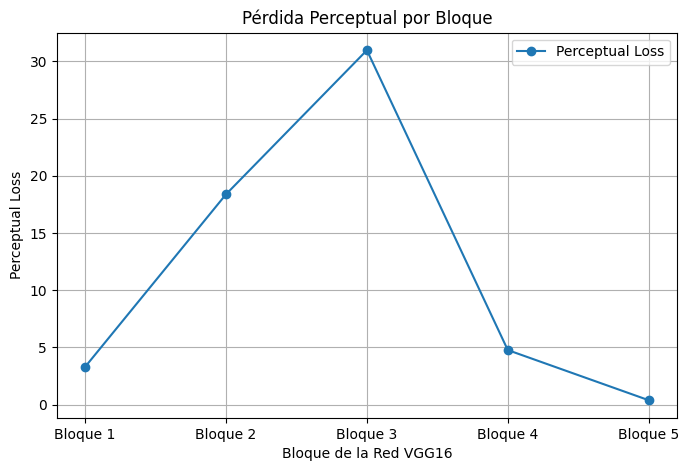

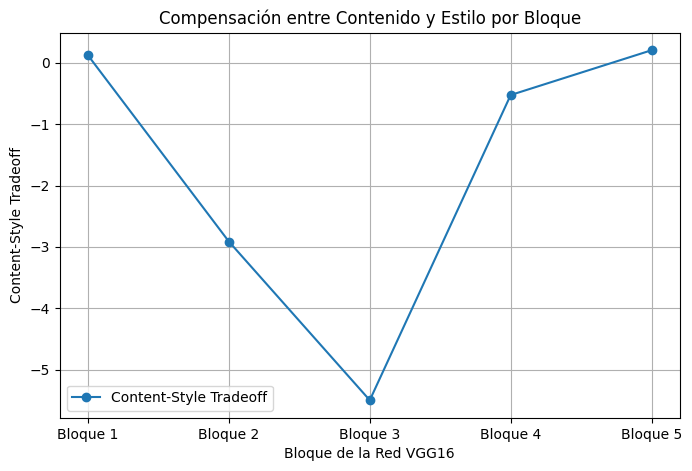


Resultados Generales:
SSIM (Content vs Generated): 0.3755
LPIPS (Style vs Generated): 0.6370


In [18]:
# Rutas de las imágenes de contenido, estilo y generada
content_img_path = '/content/Captura de pantalla 2024-12-02 214933.png'
style_img_path = '/content/Captura de pantalla 2024-12-02 214939.png'
wct_img_path = '/content/Captura de pantalla 2024-12-02 214945.png'

# Ejecutar evaluación
resultados_generales, resultados_por_bloque = evaluacion(content_img_path, style_img_path, wct_img_path, alpha=0.8)

print("\nResultados Generales:")
for key, value in resultados_generales.items():
    print(f"{key}: {value:.4f}")